## Imports and Installations

In [ ]:
import random

# Set a seed for the random number generator
random.seed(42)  # You can choose any integer as the seed

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 8.5 MB/s eta 0:00:00


In [ ]:
# Libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from warnings import filterwarnings
import random
filterwarnings('ignore')


## DATASET

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

diabetes = pd.read_csv("./Dataset/heart_failure_dataset.csv")
df = diabetes.copy()
df.head()

In [ ]:
df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time', 'DEATH_EVENT'], dtype='object')

## Removing Outliers

In [ ]:
df.DEATH_EVENT.value_counts()

0    163
1    163
Name: DEATH_EVENT, dtype: int64

In [ ]:
# Q1 = df.quantile(0.25)
# Q3 = df.quantile(0.75)
# IQR = Q3 - Q1
# print(f"Shape before removing outliers: {df.shape}")

# # Use boolean indexing to filter outliers
# outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)
# df = df[~outliers].reset_index(drop=True)

# print(f"Shape after removing outliers: {df.shape}")
# print(f"Outliers removed: {outliers.sum()}")

In [ ]:
# df_majority = df[df.DEATH_EVENT == 0]
# df_minority = df[df.DEATH_EVENT == 1]

# # Double the minority class
# df_minority_doubled = resample(df_minority,
#                                replace=True,      # sample with replacement
#                                n_samples=len(df_majority), # to double minority class
#                                random_state=123)  # reproducible results

# # Combine majority class with doubled minority class
# df_balanced = pd.concat([df_majority, df_minority_doubled])

# # Display new class counts
# print(df_balanced.DEATH_EVENT.value_counts())

In [ ]:
controllable_feature = ['diabetes','anaemia','creatinine_phosphokinase', 'serum_sodium','smoking',\
                        'high_blood_pressure','platelets','serum_creatinine','ejection_fraction']
#features which a user can potentially alter by altering their lifestyles apparently

In [ ]:
# df_balanced.to_csv('heart_failure_dataset.csv',index = False)

In [ ]:
X = df[controllable_feature]
y = df['DEATH_EVENT']

## Splitting Data and Training

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test,y_train,y_test= train_test_split(X,y,random_state=42,test_size=0.20)
X_train.shape, X_test.shape, y_test.shape,y_train.shape

((260, 9), (66, 9), (66,), (260,))

In [ ]:
# binary_col = ['anaemia', 'diabetes','high_blood_pressure','smoking']
# continuous_col = result = list(set(X_train.columns) - set(binary_col))

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test= sc.transform(X_test)
X_test_df = pd.DataFrame(X_test, columns=['diabetes', 'anaemia', 'creatinine_phosphokinase', 'serum_sodium', 'smoking', 'high_blood_pressure',
                                                          'platelets', 'serum_creatinine', 'ejection_fraction'])


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state = 42)
rf_model = rf.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.76      0.83        33
           1       0.79      0.94      0.86        33

    accuracy                           0.85        66
   macro avg       0.86      0.85      0.85        66
weighted avg       0.86      0.85      0.85        66



## Getting SHAPley values

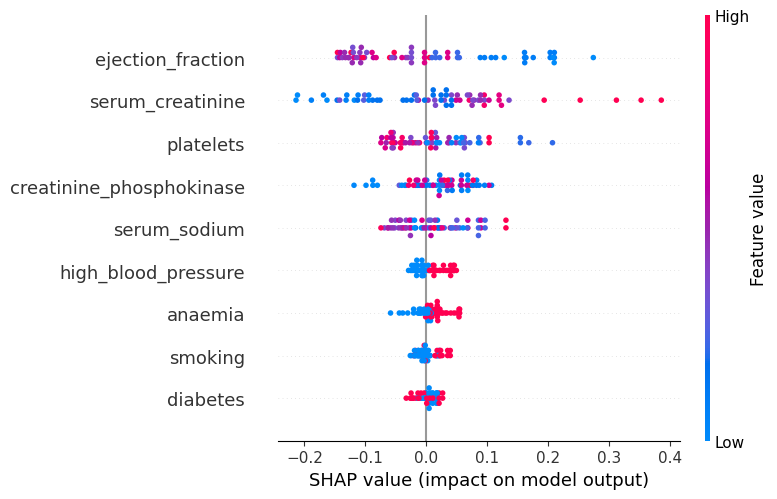

In [ ]:
import shap
explainer = shap.TreeExplainer(rf, X_train)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test, check_additivity=False)

# Create a summary plot for feature importance across all predictions
shap.summary_plot(shap_values[1], X_test, feature_names=X.columns)

In [ ]:
X_test_ID = X_test_df.copy()
X_test_ID['ID'] = [i for i in range(1, len(X_test)+1)]

In [ ]:
#shap_values = explainer(X_test)

# Create a DataFrame with SHAP values and 'ID' as a separate column
shap_df = pd.DataFrame(shap_values[1], columns=X_test_df.columns)

shap_df['ID'] = list(X_test_ID['ID'])
class_probabilities = rf.predict_proba(X_test)[:, 1]
predicted_labels = rf.predict(X_test)
shap_df['prediction'] = predicted_labels
shap_df['class_prob'] = class_probabilities

In [ ]:
shap_df.head()

,diabetes,anaemia,creatinine_phosphokinase,serum_sodium,smoking,high_blood_pressure,platelets,serum_creatinine,ejection_fraction,ID,prediction,class_prob
0,0.007,0.007,0.087,0.015,0.024,-0.006,0.064,0.096,0.164,1,1,0.990
1,0.005,0.003,-0.017,0.005,-0.026,-0.003,-0.073,0.068,0.096,2,1,0.590
2,0.010,-0.001,0.034,0.030,-0.012,-0.010,0.016,0.253,0.128,3,1,0.980
3,0.011,-0.003,0.001,-0.032,0.023,-0.024,0.050,0.072,-0.089,4,1,0.540
4,-0.001,0.018,-0.080,-0.057,0.015,-0.015,-0.058,-0.163,-0.121,5,0,0.070


In [ ]:
X_test_df.head()

,diabetes,anaemia,creatinine_phosphokinase,serum_sodium,smoking,high_blood_pressure,platelets,serum_creatinine,ejection_fraction
0,-0.816,1.114,-0.725,0.061,1.422,-0.810,-0.461,0.035,-0.953
1,-0.816,-0.898,-0.487,-0.698,-0.703,-0.810,0.387,0.035,-0.953
2,-0.816,-0.898,0.847,-0.698,-0.703,-0.810,0.223,1.757,-1.370
3,1.225,-0.898,-0.441,0.061,1.422,-0.810,-1.540,0.309,1.134
4,-0.816,1.114,-1.016,0.061,1.422,-0.810,0.433,-1.331,0.300


In [ ]:
X_test_n = X_test_df.copy()
X_test_n[controllable_feature] = sc.inverse_transform(X_test_df[controllable_feature])

In [ ]:
X_test_n['ID'] = [i for i in range(1, len(X_test)+1)]
X_test_n['label'] = list(y_test)

In [ ]:
# Set a fixed seed for reproducibility
random_state = 42

# Separate examples by class
class_0_examples = X_test_n[X_test_n['label'] == 0]
class_1_examples = X_test_n[X_test_n['label'] == 1]

# Select 13 examples labeled as '1' and 12 examples labeled as '0'
X_test_llm = pd.concat([class_0_examples.sample(12, random_state=random_state),
                        class_1_examples.sample(13, random_state=random_state)])

# The random_state parameter ensures consistent sampling


In [ ]:
shap_df_llm = shap_df[shap_df['ID'].isin(X_test_llm['ID'])]

## Designing the Prompt

In [ ]:
def getPrompts():
  prompt1 = """Hey buddy,
We want to use natural text to query a machine-learning medical model directly, bridging the gap between complex algorithmic processes and patient comprehensibility.
We have trained a machine learning model to predict the likelihood of the person getting diagnosed with Heart Failure when given a patient's vital feature data.
Given the feature list and the corresponding SHAP values for that patient, I want you to translate a simple, human-understandable explanation of how the model works, and, in case of the question request lifestyle suggestion, I want you to suggest changes to the two most important features to increase the likelihood of the person surviving.


Here is the feature list:
['diabetes', 'anaemia','creatinine_phosphokinase','serum_sodium','smoking','high_blood_pressure', 'platelets','serum_creatinine','ejection_fraction']

Here is the model prediction probability (0: No Death By Heart Failure, 1: Death By Heart Failure): """

  # prob = 0.1 # fill actual values

  prompt2 = """\n\nHere are this test subjects corresponding feature values: """

  # feature_values = [21,4,3,425,43,2]

  prompt3 = """\n\nAnd here are the corresponding SHAP values for that particular patient/record in the test set: """

  # shap_values = [2332,342,4,36,3,654,76,47]

  prompt4 = """\n\nThe Question:\n"""

  # ques = "what can I as a patient focus on to reduce my risk rate?"

  prompt5="\n\nYour Answer in no more than 250 words :\n"

  prompt6="\nYou are trying to explain it to a patient who does not have a machine learning experience and what SHAP values mean.\n"

  return prompt1, prompt2, prompt3, prompt4, prompt5,prompt6

In [ ]:
def generate_final_prompt(prob, features_values, shap_values, ques):

    prompt1, prompt2, prompt3, prompt4, prompt5, prompt6 = getPrompts()
    prompt = prompt1 + str(prob) + prompt2 + str(features_values) + prompt3 + str(shap_values) + prompt4 + str(ques) + prompt5 + prompt6

    return prompt

In [ ]:
question_list_high_risk = ["Why is the risk score so high?","What could be done to lower the risk score?","How would a change in high_blood_pressure (or/and, 'diabetes', 'anaemia', 'creatinine_phosphokinase', 'serum_sodium', 'smoking', 'platelets', 'serum_creatinine', 'ejection_fraction') affect this risk score?"]

In [ ]:
question_list_low_risk = ["What factors contributed to my low risk of diabetes?","Are there specific lifestyle changes I can make to maintain this low risk?","How would a change in high_blood_pressure (or/and, 'diabetes', 'anaemia', 'creatinine_phosphokinase', 'serum_sodium', 'smoking', 'platelets', 'serum_creatinine', 'ejection_fraction') affect this risk score?"]

In [ ]:
'''
Get the final prompts
'''

prompt_entries = []
for index, row in shap_df_llm.iterrows():
  shap_values = list(row[['diabetes', 'anaemia','creatinine_phosphokinase','serum_sodium','smoking','high_blood_pressure', 'platelets','serum_creatinine','ejection_fraction']])
  features= X_test_llm[X_test_llm['ID'] == row['ID']].iloc[0]
  features_values = list(features[['diabetes', 'anaemia','creatinine_phosphokinase','serum_sodium','smoking','high_blood_pressure', 'platelets','serum_creatinine','ejection_fraction']])
  pred = row['class_prob']
  if pred>=0.5:
    question_list = question_list_high_risk
  else:
    question_list = question_list_low_risk
  for ques in question_list:
    prompt = generate_final_prompt(pred,features_values,shap_values,ques)
    prompt_entries.append([row['ID'], prompt])

In [ ]:
df_prompts = pd.DataFrame(prompt_entries, columns=['ID', 'Prompt'])

## Inferences

In [ ]:
scaled_data_standard = sc.transform([[0.0, 1.0, 125.0, 140.0, 0.0, 1.0, 237000.0, 0.8, 45.0]])

In [ ]:
scaled_data_standard

array([[-0.81649658,  1.11417203, -0.79678397,  0.82032345, -0.7030312 ,
         1.23461405, -0.18332847, -1.05794304,  0.71698008]])

In [ ]:
rf.predict_proba(scaled_data_standard)[:, 1]

array([0.21])

## Inference

In [ ]:
scores = []
for elem in new_vector_series:
  yo = elem
  yo = yo.strip()  # This will remove leading and trailing whitespace, including '\n'

  # Step 2: Convert the modified string to a list
  yo = eval(yo)
  scaled_data_standard = sc.transform([yo])
  score = rf.predict_proba(scaled_data_standard)[:, 1]
  scores.append(score)